In [1]:
import os
import math
import pandas as pd
import numpy as np
from sodapy import Socrata
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import pyarrow as pa

socrata_token = os.environ.get("SODAPY_APPTOKEN")

We'll start by creating a cluster locally, from the resources available on your computer.

In [2]:
# from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54507,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54518,Total threads: 2
Dashboard: http://127.0.0.1:54522/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54510,


The __scheduler__ is the task manager, taking the task graph and sending tasks to the workers for execution (see the [overview in the Dask docs of all Dask schedulers](https://docs.dask.org/en/stable/scheduling.html)). The __client__ is the user-facing entry point for cluster users. The client lives where your Python code lives and communicates with the scheduler to pass along the tasks to be executed. The __workers__ do the actual computation and communicate back to to the scheduler if/when they are successful. For a deeper dive, see [the journey of a task in the Dask docs](https://distributed.dask.org/en/stable/journey.html).

<div style="text-align: center;">
<img width="65%" src="https://raw.githubusercontent.com/dask/marketing/main/source/images/distributed-overview.svg" alt="Dask overview">
</div>

Today we'll be using bicycle counter datasets from [Seattle's Open Data Portal](https://data.seattle.gov/). I've pre-selected a few locations that have more reliable counts: downtown (2nd Ave, north of Marion Street), Fremont Bridge, and Spokane St. Bridge.

<figure>
  <img src="../images/bike_counters_map.jpeg"
       width=50%
     alt="Map of Seattle bicycle counters">
  <figcaption>Image by <a>http://www.seattle.gov/transportation/projects-and-programs/programs/bike-program/bike-counters</a></figcaption>
</figure>

We'll use the [Socrata Open Data (SODA) API](https://dev.socrata.com/) to get the bicycle counter data (see the [Socrata docs](https://dev.socrata.com/docs/verbs.html) for more information on REST APIs). Without Dask, data is commonly ingested by iterating over pages of results:

In [4]:
dataset_dict = {
    'downtown': 'avwm-i8ym',
}

with Socrata("data.seattle.gov", socrata_token) as soda_client:
    results = soda_client.get(dataset_dict['downtown'], limit=2000)

results[:5]

[{'date': '2020-03-01T00:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '1',
  'sb': '3'},
 {'date': '2020-03-01T01:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '3',
  'sb': '1'},
 {'date': '2020-03-01T02:00:00.000',
  '_2nd_ave_cycletrack': '0',
  'nb': '0',
  'sb': '0'},
 {'date': '2020-03-01T03:00:00.000',
  '_2nd_ave_cycletrack': '1',
  'nb': '1',
  'sb': '0'},
 {'date': '2020-03-01T04:00:00.000',
  '_2nd_ave_cycletrack': '0',
  'nb': '0',
  'sb': '0'}]

With Dask, we can use the **Delayed** collection to parallelize what would otherwise be a sequential for-loop. For more practice using Delayed to parallelize Python code, check out the [Dask Delayed Tutorial](https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb) and [this short screencast](https://www.youtube.com/watch?v=-EUlNJI2QYs). The syntax for rewriting this to return a delayed object would be:

```python
# without Dask                               # using Dask Delayed
result = soda_client.get(                    lazy_result = dask.delayed(
    dataset_dict['downtown'], limit=2000         soda_client.get
)                                            )(dataset_dict['downtown'], limit=2000)
```

We'll define a couple functions to help us get results for all rows:

In [5]:
def _get_num_rows(data_id):
    """Helper function to dynamically pull the total rows in a dataset."""
    metadata = soda_client.get_metadata(data_id)
    num_rows = int(metadata['columns'][0]['cachedContents']['count'])
    return num_rows

def get_results(data_id, chunk_size=2000, offset=0):
    """Lazily gather all results for a dataset"""
    num_rows = _get_num_rows(data_id)
    num_chunks = math.ceil(num_rows / chunk_size)
    results = []
    for chunk in range(offset, num_chunks):
        results.append(
            dask.delayed(soda_client.get)(data_id, offset=offset, limit=chunk_size)
        )
        offset = offset + chunk_size

    return results

Now when we call `get_results` it will return a list of delayed objects that won't be evaluated until we need them

In [6]:
with Socrata("data.seattle.gov", socrata_token) as soda_client:
    results = get_results(dataset_dict['downtown'], chunk_size=7000)

In [7]:
results

[Delayed('get-373daf41-af16-4900-8a5e-76157058d04e'),
 Delayed('get-d6356efc-9e7e-479d-922d-26e01dc82eaa'),
 Delayed('get-a75aaaef-4ae7-4ee2-b918-877de56e931a'),
 Delayed('get-9c39ca13-b0c8-4666-892e-15f750776b11'),
 Delayed('get-2b8f0c98-10b9-4daa-9024-d48bb58e67d4'),
 Delayed('get-51881c3e-b741-4e7d-a5a1-8df6b79a546e'),
 Delayed('get-db131bdc-cedf-4e02-80d1-093e9f89e54b'),
 Delayed('get-08d81b30-848c-43bc-96e9-511279699033'),
 Delayed('get-c825ea5f-46fc-4949-9f2b-b93621cc7dc7'),
 Delayed('get-577faa14-ee97-4223-af76-633c28ab75dc')]

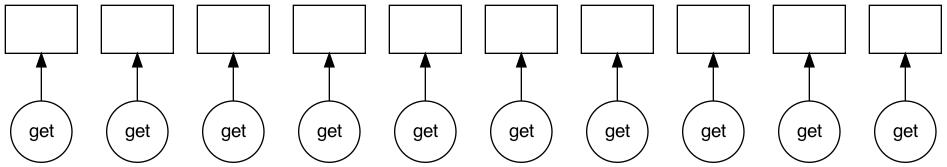

In [8]:
dask.visualize(results)

In [9]:
results[0][:5].compute()

[{'date': '2020-03-01T00:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '1',
  'sb': '3'},
 {'date': '2020-03-01T01:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '3',
  'sb': '1'},
 {'date': '2020-03-01T02:00:00.000',
  '_2nd_ave_cycletrack': '0',
  'nb': '0',
  'sb': '0'},
 {'date': '2020-03-01T03:00:00.000',
  '_2nd_ave_cycletrack': '1',
  'nb': '1',
  'sb': '0'},
 {'date': '2020-03-01T04:00:00.000',
  '_2nd_ave_cycletrack': '0',
  'nb': '0',
  'sb': '0'}]

Dask Delayed helped us parallelize the `get` function. Our data is *still* a list of dictionaries, though, which is not ideal for data manipulation. We'll use **Dask Bag** as an intermediary conversion step. Dask Bag is very helpful for pre-processing of text or JSON data. For more practice using Dask Bag, check out the [Dask Bag tutorial](https://github.com/dask/dask-tutorial/blob/main/02_bag.ipynb) and [this short screencast](https://www.youtube.com/watch?v=-qIiJ1XtSv0).

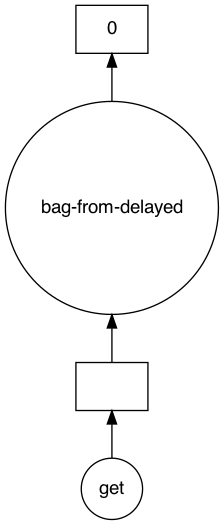

In [10]:
# import dask.bag as db

db.from_delayed(results[0]).visualize()

In [11]:
dask_bag = db.from_delayed(results)

And let's take a look at the first 3 elements:

In [12]:
dask_bag.take(3)

({'date': '2020-03-01T00:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '1',
  'sb': '3'},
 {'date': '2020-03-01T01:00:00.000',
  '_2nd_ave_cycletrack': '4',
  'nb': '3',
  'sb': '1'},
 {'date': '2020-03-01T02:00:00.000',
  '_2nd_ave_cycletrack': '0',
  'nb': '0',
  'sb': '0'})

We'll now convert the Dask Bag into a **Dask DataFrame**:

<figure>
    <img src="https://raw.githubusercontent.com/dask/marketing/main/source/images/dask-dataframe.svg" 
         width="50%"
         alt="Dask dataframe">
</figure>

Dask DataFrames are partitioned along their index where each parition is a pandas DataFrame. These pandas objects may live on disk or on other machines. Dask DataFrame implements much of the pandas API which are backed by blocked algorithms that allow for parallel and out-of-core computation. For many purposes Dask DataFrames can serve as drop-in replacements for pandas DataFrames (see the complete [Dask DataFrame API](https://docs.dask.org/en/stable/dataframe-api.html)). For more practice with Dask DataFrame, check out the [Dask DataFrame Tutorial](https://github.com/dask/dask-tutorial/blob/main/04_dataframe.ipynb)

In [13]:
dask_bag.to_dataframe()

,date,_2nd_ave_cycletrack,nb,sb
npartitions=10,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [14]:
dask_bag.to_dataframe().head()

,date,_2nd_ave_cycletrack,nb,sb
0,2020-03-01T00:00:00.000,4,1,3
1,2020-03-01T01:00:00.000,4,3,1
2,2020-03-01T02:00:00.000,0,0,0
3,2020-03-01T03:00:00.000,1,1,0
4,2020-03-01T04:00:00.000,0,0,0


Let's put it all together and watch what happens in the dashboard, specifically the workers memory, task stream, and progress tabs (see the [Dashboard Diagnostics page in the Dask documentation](https://docs.dask.org/en/stable/dashboard.html))

In [15]:
dataset_dict = {
    'downtown': 'avwm-i8ym',
    'fremont': '65db-xm6k',
    'spokane': 'upms-nr8w',
}

with Socrata("data.seattle.gov", socrata_token) as soda_client:
    downtown = get_results(dataset_dict['downtown'], chunk_size=7000)
    fremont = get_results(dataset_dict['fremont'], chunk_size=7000)
    spokane = get_results(dataset_dict['spokane'], chunk_size=7000)

ddf = dd.concat([
    # downtown, 2nd ave dataset
    (db.from_delayed(downtown)
     .to_dataframe()
     .assign(location='downtown')
     .rename(columns={'_2nd_ave_cycletrack': 'total'})),
    # fremont bridge dataset
    (db.from_delayed(fremont)
     .to_dataframe()
     .assign(location='fremont')
     .rename(columns={'fremont_bridge': 'total'})),
    # spokane street dataset
    (db.from_delayed(spokane)
     .to_dataframe()
     .assign(location='spokane')
     .rename(columns={'spokane_st_bridge_total': 'total'}))
]).drop(
    ['west', 'east', 'fremont_bridge_sb', 'fremont_bridge_nb', 'nb', 'sb'],
    axis=1
)

# add some additional columns
ddf['ds'] = dd.to_datetime(ddf['date'])
ddf['y'] = dd.to_numeric(ddf['total'], errors='coerce')
ddf['day_of_week'] = ddf['ds'].dt.day_of_week
ddf['is_weekend'] = ddf['day_of_week'].apply(lambda x: True if x in [5, 6] else False, meta=('day_of_week', bool))

### What is the average number of cyclists per hour on weekends vs. weekdays?

In [16]:
ddf[ddf["y"].notnull()].groupby(["location", "is_weekend"])["y"].mean().compute()

location  is_weekend
downtown  False          36.333772
          True           14.489825
fremont   False         127.869266
          True           63.881852
spokane   False          37.202372
          True           21.737574
Name: y, dtype: float64

### Which days of the week have the highest and lowest average cyclists per hour?

For this next computation, we'll try out a way to improve performance by sharing an intermediate operation across two `dask.compute` calls. For most operations, Dask DataFrame hashes the arguments, allowing duplicate operations to be shared, and only computed once. This is because the task graphs for both results are merged when calling `dask.compute`.

In [17]:
day_avg_lazy = ddf[ddf["y"].notnull()].groupby(["day_of_week"])["y"].mean()

In [18]:
day_high, day_low = dask.compute(day_avg_lazy.idxmax(), day_avg_lazy.idxmin())
print(day_high) # Tuesday is the highest
print(day_low) # Sunday the lowest

1
6


You `dask.visualize(day_avg_lazy.idxmax(), day_avg_lazy.idxmin())` to see the resulting task graph and which operations are shared.

# Time series forecasting with Prophet

This example was adapted from the [Dask example on time series forecasting](https://examples.dask.org/applications/forecasting-with-prophet.htmlhttps://examples.dask.org/applications/forecasting-with-prophet.html). [Prophet](https://facebook.github.io/prophet/) is a "a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality". The first few lines of code won't use Dask at all:

In [19]:
from prophet import Prophet
import prophet.diagnostics

In [20]:
df = ddf[ddf['location'] == 'fremont'].compute()

<AxesSubplot:xlabel='ds'>

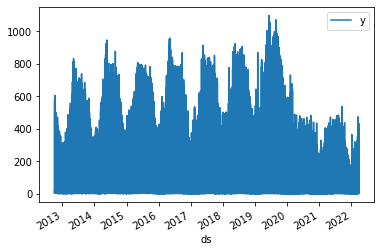

In [21]:
df.plot(x='ds', y='y')

In [22]:
%%time
m = Prophet()
m.fit(df)

Initial log joint probability = -1736.7
CPU times: user 39.6 s, sys: 1.8 s, total: 41.4 s
Wall time: 41.4 s


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        293770   0.000568927        765.49      0.4887      0.4887      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        293813     0.0007342        1431.2       0.422       0.422      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        293826    0.00100134       322.193           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        293837    0.00110756       562.297           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     491        293838   1.99864e-05       238.052   1.132e-07       0.001      626  LS failed, Hessian reset 
     499        293838   2.40261e-05       112.197           1           1      6

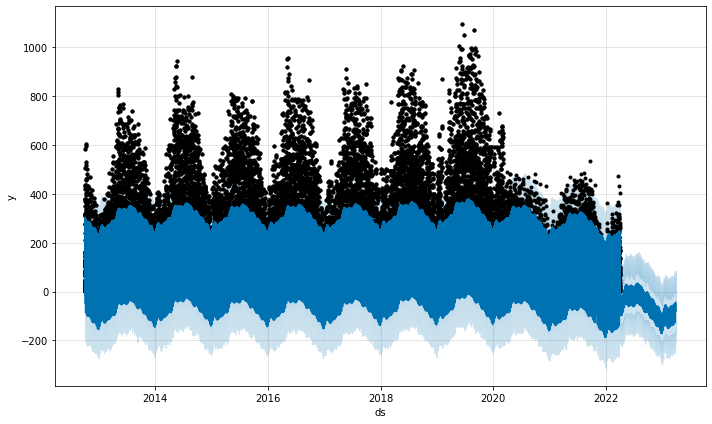

In [23]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

Dask isn't used at all in the above snippets, but where it really comes in handy is for cross validation, where simulated historical forecasts to provide some idea of a model’s quality. With the `parallel="dask"` argument, we can run these models in parallel rather than serially:

In [24]:
%%time
df_cv = prophet.diagnostics.cross_validation(
    m, initial="730 days", period="180 days", horizon="365 days",
    parallel="dask"
);

INFO:prophet:Making 14 forecasts with cutoffs between 2014-11-03 23:00:00 and 2021-03-31 23:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:54507' processes=4 threads=8, memory=16.00 GiB>


Initial log joint probability = -547.821
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70057.7    0.00036299       378.513           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       70058.4   6.77696e-05       148.978   7.245e-07       0.001      222  LS failed, Hessian reset 
     199       70058.9    0.00012723       190.826           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       70059.5   0.000187227       126.544           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       70059.6   2.70576e-05       139.836   7.359e-08       0.001      489  LS failed, Hessian reset 
     399       70059.8   8.77548e-05       102.382           1           1      591   
    Iter      log pro

In [25]:
cluster.close()